### Road segmentation with CNN
Author: fvilmos
https://github.com/fvilmos

- uses a CNN based segmentation network with 2 skipp connections, similar to FCN16
- the input is an RGB image, the output the segmentation mask with the same dimensions as the input

In [1]:
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import glob
import json
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
from PIL import Image,ImageFilter
from utils import config
from utils import utils
import seaborn as sb


USE_GPU=config.USE_GPU

if USE_GPU==1:
    def get_available_gpus():
        local_device_protos = device_lib.list_local_devices()
        return [x.name for x in local_device_protos if x.device_type == 'GPU']
    print (get_available_gpus())
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

['/device:GPU:0']


In [2]:
IMG_W = config.IMG_W
IMG_H = config.IMG_H
IMG_CHANNELS = config.IMG_CHANNELS
NET_SHAPE = config.NET_SHAPE


BATCH_SIZE = 8
SPLIT = 0.70
data_location = config.DATA_LOCATION

file = config.FILE

files = glob.glob(data_location + file, recursive=True)
print (data_location + file, "Meta file number: ", len(files))

.\_data\**\*info.rec Meta file number:  2


### Data loader 
to load automatically a defined batch amount of data

In [3]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, data, batch_size, use_random=True,input_shape=[200,150,3], net_shape=[200,150], file_tags=['']):
        self.batch_size = batch_size
        self.use_random = use_random
        self.data = data
        if self.use_random == True:
            np.random.shuffle(self.data)
        self.input_shape = input_shape
        self.net_shape=net_shape
        
    # get data lenght
    def __len__(self):
        return len(self.data)//self.batch_size
    
    # get item form batch
    def __getitem__(self, indx):
        batch_data = self.data[indx*self.batch_size:(indx+1)*self.batch_size]
        #print (batch_data)
        
        X = []
        y = []
        for it in batch_data:
            v_data = cv2.imread(it['rgb_c'])
            v_data = cv2.resize(v_data,dsize=(self.input_shape[0],self.input_shape[1]))
                        
            if self.input_shape[2] == 1:
                v_data = cv2.cvtColor(v_data, cv2.COLOR_RGB2GRAY)
            
            v_data = utils.fast_normalization(v_data)
            
            
            # create label
            v_label = cv2.imread(it['depth_c'])
            v_label = cv2.resize(v_label,dsize=(self.net_shape[0],self.net_shape[1]))
            v_label = utils.fast_normalization(v_label)
            
            X.append(v_data)
            y.append(v_label)
                        
            
        X = np.array(X)
        y = np.array(y)
        
        return X,y
            
    
    # do something on epoch end
    def on_epoch_end(self):
        if self.use_random == True:
            np.random.shuffle(self.data)
            
data = []

fn_filter = [lambda x: True]

for file in files:
    print ("Loading:",file)
    data.extend(utils.load_data(file,filter_fn=fn_filter, file_tag=['depth_c','rgb_c']))

data = np.array(data)
print (len(data))
np.random.shuffle(data)

# split the data
train, val, test = np.split(data,[int(len(data)*SPLIT), int(len(data)*0.9)])
print ("Sample_nr:",len(data), " Train:", len(train), " Val:",len(val), "Test:", len(test))

obj_data_train= DataLoader(train, batch_size=BATCH_SIZE, input_shape=[NET_SHAPE[0],NET_SHAPE[1],IMG_CHANNELS], net_shape=NET_SHAPE)
obj_data_val= DataLoader(val, batch_size=BATCH_SIZE, input_shape=[NET_SHAPE[0],NET_SHAPE[1],IMG_CHANNELS], net_shape=NET_SHAPE)

obj_data_test= DataLoader(test, batch_size=BATCH_SIZE, input_shape=[NET_SHAPE[0],NET_SHAPE[1],IMG_CHANNELS], net_shape=NET_SHAPE)

Loading: .\_data\2022-10-21_23-25-04\_info.rec
Loading: .\_data\2022-10-21_23-31-06\_info.rec
8044
Sample_nr: 8044  Train: 5630  Val: 1609 Test: 805


### Visualize data
Take the input image and overlay over it the segmentation mask

(8, 240, 320, 3) (8, 240, 320, 3)


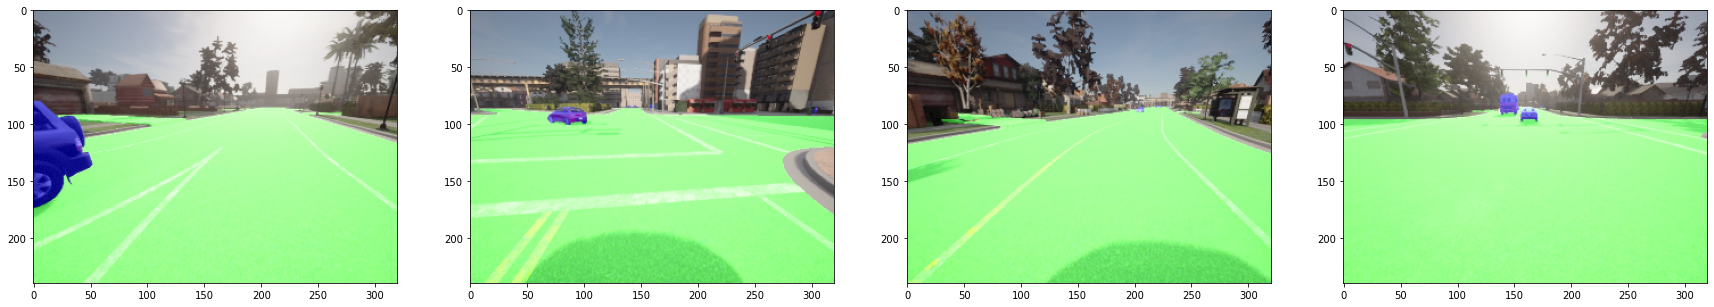

In [4]:
test_sample=obj_data_train.__getitem__(0)
print (test_sample[0].shape, test_sample[1].shape)

fig, axs = plt.subplots(nrows=1,ncols=test_sample[0].shape[0]//2)
fig.set_size_inches(30,60)
for i in range (len(test_sample[0])//2):
    sin = test_sample[0][i]*255
    sout = test_sample[1][i]*255
    sin = cv2.cvtColor(sin.astype(np.uint8),cv2.COLOR_BGR2RGB)
    sout = cv2.cvtColor(sout.astype(np.uint8),cv2.COLOR_BGR2RGB)
    
    img = cv2.addWeighted(sin, 1, sout,0.5, 1)
    axs[i].imshow(img)

    

### Create the segmentation network

Model: "seg_net2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 128 9728        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 120, 160, 128 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 120, 160, 64) 131136      dropout_3[0][0]                  
___________________________________________________________________________________________

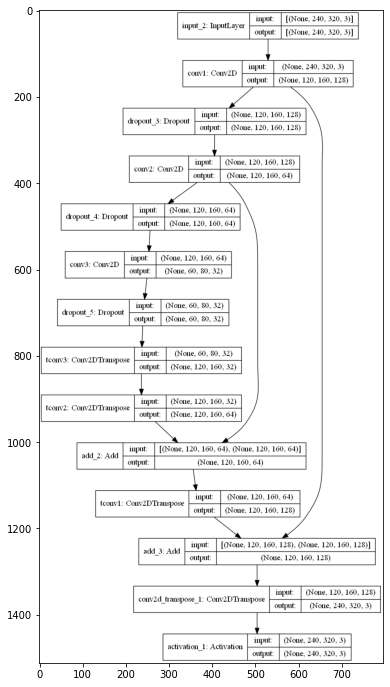

In [11]:
def seg_model(img_size=[200,160], img_channels=3, batch_size=8, name="seg_net2"):
    
    data_in = keras.Input(shape=(img_size[1],img_size[0],img_channels))

    val_c1 = keras.layers.Conv2D(128,(5,5), strides=(2,2), activation="relu", padding="SAME", name="conv1")(data_in)
    val = keras.layers.Dropout(0.2)(val_c1)
    
    val_c2 = keras.layers.Conv2D(64,(4,4), strides=(1,1), activation="relu", padding="SAME", name="conv2")(val)
    val = keras.layers.Dropout(0.2)(val_c2)
    
    val = keras.layers.Conv2D(32,(4,4), strides=(2,2), activation="relu", padding="SAME", name="conv3")(val)
    val = keras.layers.Dropout(0.2)(val)


    val = keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2), activation="relu", padding="SAME", name="tconv3")(val)
    
    val = keras.layers.Conv2DTranspose(64,(2,2),strides=(1,1), activation="relu", padding="SAME", name="tconv2")(val)
    val = keras.layers.Add()([val, val_c2])
    
    val = keras.layers.Conv2DTranspose(128,(2,2),strides=(1,1), activation="relu", padding="SAME", name="tconv1")(val)
    val = keras.layers.Add()([val, val_c1])
    
    val = keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2), padding="SAME")(val)

    out = keras.layers.Activation("sigmoid")(val)
    
    model = keras.Model(inputs=data_in,outputs=out, name=name)
    model.summary()
    keras.utils.plot_model(model,to_file=".\\info\\"+name+".png",show_shapes=True)

    model.compile(optimizer=keras.optimizers.Adam(),loss=[keras.losses.mae], metrics=['mae'])
    print (data_in.shape, out.shape)

    img = plt.imread(".\\info\\"+ name + '.png')
    plt.figure(figsize=(10,12))
    plt.imshow(img)

    return model


# create the model
model = seg_model(img_size=[NET_SHAPE[0],NET_SHAPE[1]])

### Train the model

Epoch 1/30
703/703 [==============================] - 115s 157ms/step - loss: 0.1460 - mae: 0.1460 - val_loss: 0.0401 - val_mae: 0.0401

Epoch 00001: val_loss improved from inf to 0.04006, saving model to seg.h5
Epoch 2/30


C:\Miniconda3\envs\py37_tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


703/703 [==============================] - 109s 155ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0221 - val_mae: 0.0221

Epoch 00002: val_loss improved from 0.04006 to 0.02208, saving model to seg.h5
Epoch 3/30
703/703 [==============================] - 110s 156ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0191 - val_mae: 0.0191

Epoch 00003: val_loss improved from 0.02208 to 0.01910, saving model to seg.h5
Epoch 4/30
703/703 [==============================] - 110s 156ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0185 - val_mae: 0.0185

Epoch 00004: val_loss improved from 0.01910 to 0.01845, saving model to seg.h5
Epoch 5/30
703/703 [==============================] - 110s 156ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0165 - val_mae: 0.0165

Epoch 00005: val_loss improved from 0.01845 to 0.01655, saving model to seg.h5
Epoch 6/30
703/703 [==============================] - 111s 158ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0168 - val_mae: 0.0168

Epoch 0000

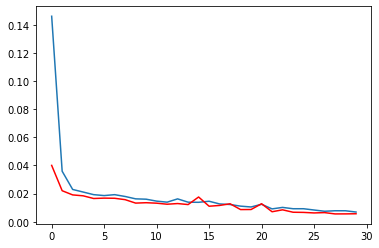

In [6]:
# model train
epochs = 30
steps = 100

checkpoint = ModelCheckpoint(filepath='seg.h5', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=5, verbose=1, mode='auto')

hist = model.fit(x=obj_data_train,validation_data=obj_data_val, epochs=epochs, callbacks=[checkpoint,early_stop])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], c='r')

### Compute model metrics

In [7]:
from sklearn.metrics import jaccard_score
model = keras.models.load_model(config.MODEL_FILE)
res_eval = model.evaluate(x=obj_data_test)
print (res_eval)

jscore = []
for b in range (len(obj_data_test)):
    test_sample=obj_data_test.__getitem__(0)
    for i in range (len(test_sample[0])):
        sin = test_sample[0][i]
        sout_true = test_sample[1][i]
        
        imgs = cv2.resize(sin.copy(), dsize=config.NET_SHAPE)
        nimg = np.array([imgs])
        mret = model.predict(nimg,batch_size=1)
        
        sin = np.array(sin*255).astype(np.uint8)
        sout = np.array(mret[0]*255).astype(np.uint8)
        sout_true = np.array(sout_true*255).astype(np.uint8)
    
        js = jaccard_score(y_true=sout_true.flatten(),y_pred=sout.flatten(), average="micro")
        
        jscore.append(js)

print ('Average IOU: {:.2f}'.format(np.average(np.array(jscore))))
    

100/100 [==============================] - 12s 114ms/step - loss: 0.0054 - mae: 0.0054
[0.005405583418905735, 0.005405583884567022]
Average IOU: 0.80


### Test detections

(8, 240, 320, 3) (8, 240, 320, 3)


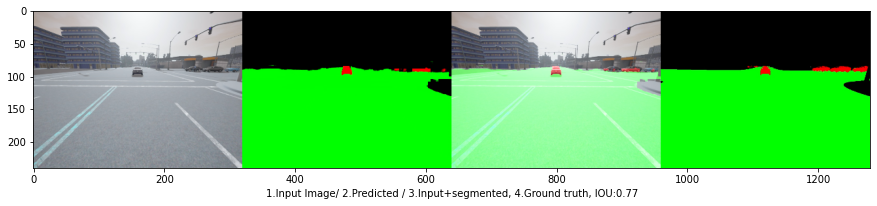

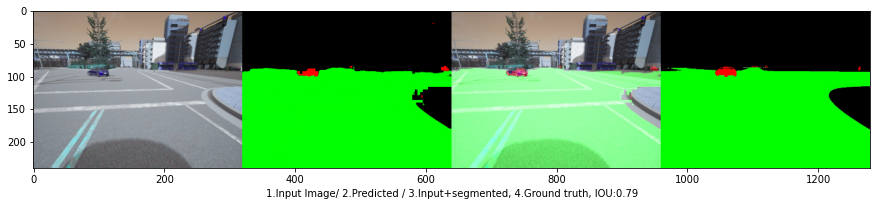

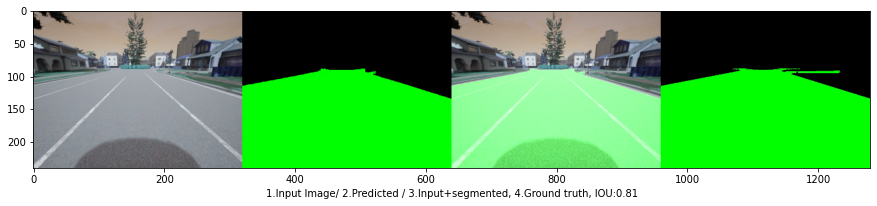

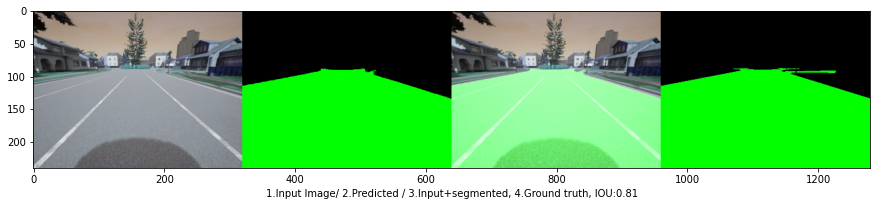

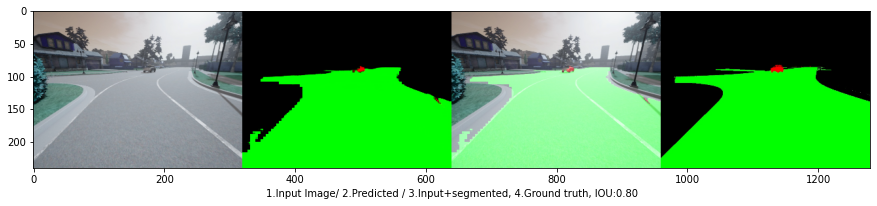

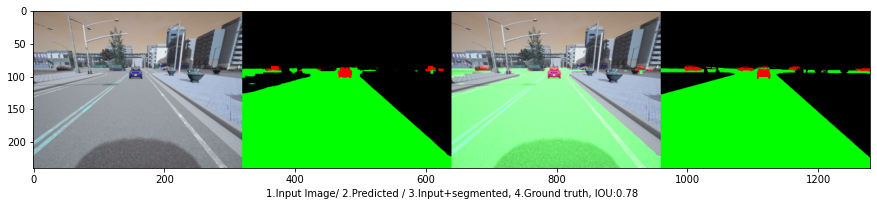

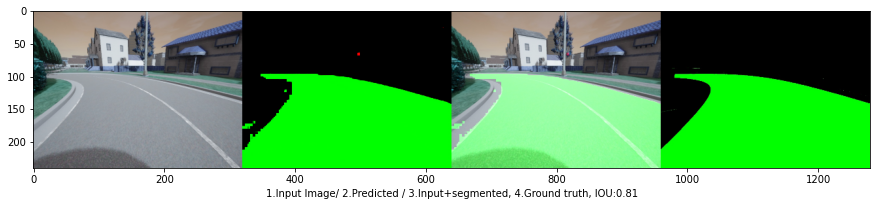

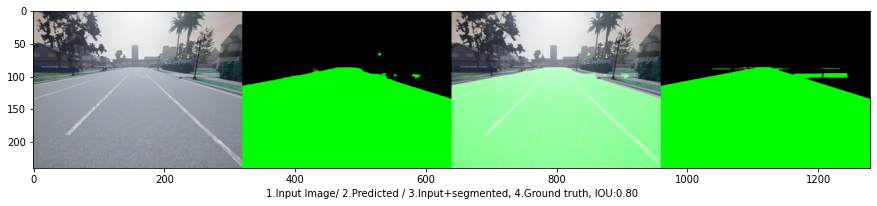

In [10]:
from sklearn.metrics import jaccard_score
test_sample=obj_data_test.__getitem__(0)
print (test_sample[0].shape, test_sample[1].shape)

for i in range (len(test_sample[0])):
    sin = test_sample[0][i]
    sout_true = test_sample[1][i]
    
    imgs = cv2.resize(sin.copy(), dsize=config.NET_SHAPE)

    nimg = np.array([imgs])
    mret = model.predict(nimg,batch_size=1)

    #sout = cv2.cvtColor(sin.astype(np.uint8),cv2.COLOR_BGR2RGB)
    sin = np.array(sin*255).astype(np.uint8)
    sout = np.array(mret[0]*255).astype(np.uint8)
    sout_true = np.array(sout_true*255).astype(np.uint8)
    
    jscore = jaccard_score(y_true=sout_true.flatten(),y_pred=sout.flatten(), average="micro")
    
    img_over = cv2.addWeighted(sin,1,sout,0.5, 1)
    img = cv2.hconcat([sin,sout, img_over, sout_true])
    plt.figure(figsize=(15,10))
    plt.xlabel("1.Input Image/ 2.Predicted / 3.Input+segmented, 4.Ground truth, IOU:{:.2f}".format(jscore))
    plt.imshow(img)
    plt.show()
    